## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install additional dependencies
# !pip install datasets matplotlib pandas pillow tqdm

# # Install older pyzmq and jupyter client versions
# !pip install --upgrade "jupyter_client<8" "pyzmq<25"

# # Install utility packages
# !pip install cjm_pandas_utils cjm_pil_utils cjm_pytorch_utils

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from copy import copy
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random

# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor, move_data_to_device
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy 
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes, draw_keypoints
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Loading and Exploring the Dataset

### Setting the Directory Paths

In [3]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Dataset Directory:,/mnt/980_1TB_2/Datasets
Archive Directory:,/mnt/980_1TB_2/Datasets/../Archive


### Setting the Dataset Path

In [4]:
# Set the name of the dataset
dataset_name = 'labelme-keypoint-toy-dataset'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/labelme-keypoint-toy-dataset
Archive Path:,/mnt/980_1TB_2/Datasets/../Archive/labelme-keypoint-toy-dataset.zip
Dataset Path:,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset


### Downloading the Dataset

In [5]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/labelme-keypoint-toy-dataset/resolve/main/labelme-keypoint-toy-dataset.zip
Dataset folder already exists


### Getting the Image and Annotation Folders

In [6]:
# Get a list of image files in the dataset
img_file_paths = get_img_files(dataset_path)

# Get a list of JSON files in the dataset
annotation_file_paths = list(dataset_path.glob('*.json'))

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image File": [file.name for file in img_file_paths], 
              "Annotation File":[file.name for file in annotation_file_paths]}).head()

,Image File,Annotation File
0,133196.jpg,133196.json
1,245035.jpg,245035.json
2,245036.jpg,245036.json
3,247937.jpg,247937.json
4,3172614.jpg,3172614.json


### Get Image File Paths

In [7]:
# Create a dictionary that maps file names to file paths
img_dict = {file.stem : file for file in img_file_paths}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 38


,0
133196,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/133196.jpg
245035,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/245035.jpg
245036,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/245036.jpg
247937,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/247937.jpg
3172614,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/3172614.jpg


### Get Image Annotations

In [8]:
# Create a generator that yields Pandas DataFrames containing the data from each JSON file
cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))

# Concatenate the DataFrames into a single DataFrame
annotation_df = pd.concat(cls_dataframes, ignore_index=False)

# Assign the image file name as the index for each row
annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
annotation_df = annotation_df.set_index('index')

# Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
annotation_df = annotation_df.loc[list(img_dict.keys())]

# Print the first 5 rows of the DataFrame
annotation_df.head()

  0%|          | 0/38 [00:00<?, ?it/s]

,version,flags,shapes,imagePath,imageData,imageHeight,imageWidth
index,,,,,,,
133196,5.3.1,{},"[{'label': 'nose', 'points': [[386.70731707317077, 297.109756097561]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",133196.jpg,None,768,960
245035,5.3.1,{},"[{'label': 'nose', 'points': [[334.4587155963303, 319.57798165137615]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",245035.jpg,None,1152,768
245036,5.3.1,{},"[{'label': 'nose', 'points': [[226.8571428571429, 240.80357142857144]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",245036.jpg,None,1120,768
247937,5.3.1,{},"[{'label': 'nose', 'points': [[454.6585365853659, 230.03658536585363]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",247937.jpg,None,768,1152
3172614,5.3.1,{},"[{'label': 'nose', 'points': [[539.4146341463414, 608.0853658536585]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",3172614.jpg,None,768,1152


In [9]:
# Explode the 'shapes' column in the annotation_df dataframe
# Convert the resulting series to a dataframe and rename the 'shapes' column to 'shapes'
# Apply the pandas Series function to the 'shapes' column of the dataframe
shapes_df = annotation_df['shapes'].explode().to_frame().shapes.apply(pd.Series)

In [10]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = shapes_df['label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,nose


### Visualizing Keypoint Annotations

#### Generate a color map

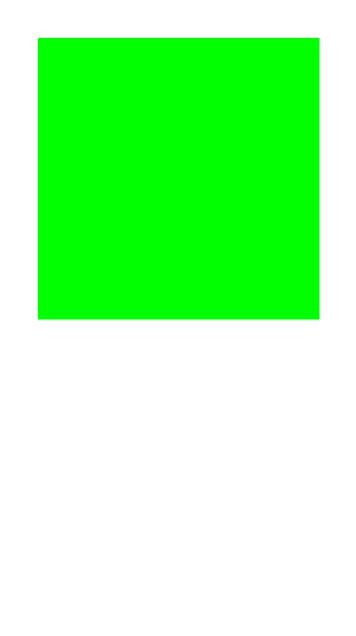

In [11]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [12]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [13]:
draw_bboxes = partial(draw_bounding_boxes, fill=True, width=2, font=font_file, font_size=25)

#### Inspect the corresponding annotation data

In [14]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[list(img_dict.keys())[0]].to_frame()

,133196
version,5.3.1
flags,{}
shapes,"[{'label': 'nose', 'points': [[386.70731707317077, 297.109756097561]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]"
imagePath,133196.jpg
imageData,None
imageHeight,768
imageWidth,960


In [15]:
import xml.etree.ElementTree as ET
import xml.dom.minidom

def prettify(elem):
    """Return a pretty-printed XML string for the Element."""
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = xml.dom.minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

def convert_keypoints(keypoints):
    """Convert keypoints from custom format to CVAT format."""
    converted = []
    for image_keypoints in keypoints:
        image_converted = []
        for keypoint in image_keypoints:
            for label, coords in keypoint.items():
                cvat_keypoint = {
                    "label": label,
                    "points": ",".join(map(str, coords))  # x1,y1,x2,y2,...
                }
                image_converted.append(cvat_keypoint)
        converted.append(image_converted)
    return converted

def create_cvat_xml(labels, keypoints, colors, dims, image_names, file_name):
    converted_keypoints = convert_keypoints(keypoints)

    annotations = ET.Element("annotations")
    version = ET.SubElement(annotations, "version")
    version.text = "1.1"

    # Meta information (modify as needed)
    meta = ET.SubElement(annotations, "meta")
    task = ET.SubElement(meta, "task")
    ET.SubElement(task, "id").text = "1"  # Example ID
    ET.SubElement(task, "name").text = "Image Annotation Task"
    ET.SubElement(task, "size").text = str(len(dims))
    ET.SubElement(task, "mode").text = "annotation"
    ET.SubElement(task, "overlap").text = "0"

    # Defining labels
    labels_elem = ET.SubElement(task, "labels")
    for label, color in zip(labels, colors):
        label_elem = ET.SubElement(labels_elem, "label")
        ET.SubElement(label_elem, "name").text = label
        ET.SubElement(label_elem, "color").text = f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}"
        ET.SubElement(label_elem, "type").text = "points"  # Change to 'points'

    # Images and keypoints
    for i, (dim, keypoints_per_image, image_name) in enumerate(zip(dims, converted_keypoints, image_names)):
        image_elem = ET.SubElement(annotations, "image", id=str(i), name=image_name, width=str(dim[0]), height=str(dim[1]))
        for keypoint in keypoints_per_image:
            ET.SubElement(image_elem, "points", label=keypoint["label"], points=keypoint["points"], occluded="0")

    # Writing to file with pretty print
    with open(file_name, "w") as file:
        file.write(prettify(annotations))

In [16]:
points = [[{ shape['label'] : np.array(shape['points']).reshape(2).tolist()} for shape in shapes] for shapes in annotation_df['shapes']]

In [18]:
colors = int_colors
dims = annotation_df[['imageHeight', 'imageWidth']].values.tolist()

In [19]:
create_cvat_xml(class_names, points, colors, dims, annotation_df.index.tolist(), "output.xml")